In [ ]:
!pip install shapely xarray netCDF4 pandas matplotlib
!pip install gradio matplotlib tensorflow tensorflow.keras scikit-learn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
import seaborn as sns
import datetime
import time
import gradio as gr
import argparse
import xarray as xr
import glob
from scipy.stats import pearsonr
import io
import base64
from PIL import Image
import re
import pickle
import gc

tf.config.run_functions_eagerly(True)
np.random.seed(42)
tf.random.set_seed(42)

# Configuration parameters
config = {
    'data_path': 'sample_data/GLDAS_NOAH025_3H.A20241130.1800.021.nc4',
    'output_model_path': 'models/water_requirement_model.h5',
    'output_pickle_path': 'models/water_requirement_model.pkl',
    'input_variables': ['SoilMoi0_10cm_inst', 'Tair_f_inst', 'Rainf_f_tavg', 'Qair_f_inst', 'Wind_f_inst'],
    'target_variable': 'Evap_tavg',
    'batch_size': 32,
    'epochs': 30,
    'validation_split': 0.2,
    'test_split': 0.1,
    'spatial_dims': (16, 16),
    'share': True,
    'debug': False,
    'data_dir': 'datasets',
    'memory_growth': True
}

# Configure GPU memory growth to prevent OOM errors
if config['memory_growth']:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except:
        # No GPU available or cannot modify virtual devices
        pass


class WaterIrrigationML:
    def __init__(self, config, mode='demo'):
        self.config = config
        self.model = None
        self.mode = mode
        self.history = None
        self.test_data = None
        self.confusion_thresholds = [2, 5, 10]

        # Define fixed scaling parameters(max values, min values) for input features
        self.feature_mins = np.array([0, -20, 0, 0, 0])
        self.feature_maxs = np.array([100, 50, 100, 100, 30])

        self.output_min = 0
        self.output_max = 20

        os.makedirs(os.path.dirname(self.config['output_model_path']), exist_ok=True)
        os.makedirs(self.config['data_dir'], exist_ok=True)

        self.performance_metrics = {
            'rmse': None,
            'mae': None,
            'r2': None,
            'pearson_r': None,
            'confusion_matrix': None,
            'precision': None,
            'recall': None,
            'f1_score': None
        }

    def prepare_input_data(self, soil_moisture, temperature, precipitation, humidity, wind_speed):
        """Prepare input data for prediction with consistent scaling"""
        try:
            features = np.array([
                float(soil_moisture),
                float(temperature),
                float(precipitation),
                float(humidity),
                float(wind_speed)
            ]).reshape(1, -1)

            # Applying min-max scaling manually using fixed parameters
            features_scaled = (features - self.feature_mins) / (self.feature_maxs - self.feature_mins)
            features_scaled = np.clip(features_scaled, 0, 1)

            # Creating a spatial grid
            features_reshaped = np.zeros((1, *self.config['spatial_dims'], len(self.config['input_variables'])))
            for i in range(len(self.config['input_variables'])):
                base_value = features_scaled[0, i]
                grid = np.ones(self.config['spatial_dims']) * base_value
                variation = np.random.normal(0, 0.05, self.config['spatial_dims'])
                grid += variation
                grid = np.clip(grid, 0, 1)
                features_reshaped[0, :, :, i] = grid

            return features_reshaped
        except ValueError as e:
            raise ValueError(f"Error preparing input data: {str(e)}. Please check input values.")

    def predict_water_requirement(self, soil_moisture, temperature, precipitation, humidity, wind_speed):
        """Make prediction using the trained model with improved handling"""
        try:
            soil_moisture = float(soil_moisture)
            temperature = float(temperature)
            precipitation = float(precipitation)
            humidity = float(humidity)
            wind_speed = float(wind_speed)

            if self.model is None:
                self.load_model()

            # Calculate water requirement using formula
            temp_factor = 0.2 * temperature if temperature <= 30 else 6 + 0.4 * (temperature - 30)
            precip_effect = precipitation * 0.8 if precipitation <= 10 else 8 + (precipitation - 10) * 0.4
            humidity_factor = 1.0 + (80 - humidity) / 80 if humidity >= 20 else 1.75 + (20 - humidity) / 20
            wind_factor = 1.0 + (wind_speed / 15) if wind_speed <= 3 else 1.2 + (wind_speed - 3) / 10
            soil_factor = 1.0 + (70 - soil_moisture) / 100 if soil_moisture >= 30 else 1.4 + (30 - soil_moisture) / 30
            base_requirement = max(temp_factor - precip_effect, 0)
            calculated_requirement = base_requirement * humidity_factor * wind_factor * soil_factor
            calculated_requirement = max(0, min(20, calculated_requirement))

            final_value = calculated_requirement
            if self.model is not None:
                try:
                    features = self.prepare_input_data(soil_moisture, temperature, precipitation, humidity, wind_speed)
                    prediction = self.model.predict(features, verbose=0)
                    model_component = np.mean(prediction) * self.output_max

                    # Combining model output with formula
                    final_value = (model_component * 0.7 + calculated_requirement * 0.3)

                    # Extreme cases
                    if temperature > 40 and humidity < 20 and soil_moisture < 25:
                        final_value = max(final_value, 12.0)
                    elif temperature < 10 and humidity > 80:
                        final_value = min(final_value, 5.0)
                    elif precipitation > 15:
                        final_value = min(final_value, precipitation * 0.3)

                    final_value = max(0, min(20, final_value))
                except Exception as model_error:
                    print(f"Model prediction failed, using formula only: {str(model_error)}")
                    final_value = calculated_requirement

            current_time = datetime.datetime.now().strftime("%A, %B %d, %Y, %I:%M %p")
            result = f"### Predicted Water Requirement\n\n"
            result += f"**Water Requirement:** {final_value:.2f} mm/day\n\n"
            result += f"**Based on:**\n"
            result += f"- Soil Moisture: {soil_moisture}%\n"
            result += f"- Temperature: {temperature}°C\n"
            result += f"- Precipitation: {precipitation} mm/day\n"
            result += f"- Humidity: {humidity}%\n"
            result += f"- Wind Speed: {wind_speed} m/s\n\n"
            result += f"**Prediction Time:** {current_time}"

            return result

        except Exception as e:
            # In case of error in model loading, prediction only using formula
            try:
                soil_moisture = float(soil_moisture)
                temperature = float(temperature)
                precipitation = float(precipitation)
                humidity = float(humidity)
                wind_speed = float(wind_speed)

                temp_component = temperature * 0.2 if temperature <= 25 else 5 + (temperature - 25) * 0.5
                precip_component = min(precipitation * 0.7, temp_component * 0.8)
                humid_component = (100 - humidity) / 33.3
                wind_component = wind_speed / 5
                soil_component = (100 - soil_moisture) / 20

                basic_estimate = temp_component - precip_component + wind_component + humid_component + soil_component
                basic_estimate = max(1.0, min(20.0, basic_estimate))

                current_time = datetime.datetime.now().strftime("%A, %B %d, %Y, %I:%M %p")
                result = f"### Fallback Prediction\n\n"
                result += f"**Water Requirement:** {basic_estimate:.2f} mm/day\n\n"
                result += f"**Based on:**\n"
                result += f"- Soil Moisture: {soil_moisture}%\n"
                result += f"- Temperature: {temperature}°C\n"
                result += f"- Precipitation: {precipitation} mm/day\n"
                result += f"- Humidity: {humidity}%\n"
                result += f"- Wind Speed: {wind_speed} m/s\n\n"
                result += f"**Prediction Time:** {current_time}\n\n"
                result += f"*Note: Using basic estimate due to error: {str(e)}*"

                return result

            except Exception:
                return f"Error calculating water requirement. Please check your input values and try again."

    def extract_prediction_value(self, prediction_text):
        """Safely extract numeric prediction value from formatted text"""
        try:
            # Find the water requirement value using regex
            pattern = r"Water Requirement:\*\* (\d+\.\d+)"
            match = re.search(pattern, prediction_text)
            if match:
                return float(match.group(1))

            pattern = r"Water Requirement: (\d+\.\d+)"
            match = re.search(pattern, prediction_text)
            if match:
                return float(match.group(1))

            pattern = r"(\d+\.\d+)"
            match = re.search(pattern, prediction_text)
            if match:
                return float(match.group(1))

            return None
        except Exception:
            return None

    def build_model(self):
        """Build a more robust CNN model"""
        input_shape = (*self.config['spatial_dims'], len(self.config['input_variables']))
        spatial_inputs = Input(shape=input_shape)

        # CNN convolutional blocks
        conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(spatial_inputs)
        bn1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

        conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
        bn2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

        conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
        bn3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

        flat = Flatten()(pool3)

        dense1 = Dense(128, activation='relu')(flat)
        bn4 = BatchNormalization()(dense1)
        drop1 = Dropout(0.3)(bn4)

        dense2 = Dense(64, activation='relu')(drop1)
        bn5 = BatchNormalization()(dense2)
        drop2 = Dropout(0.2)(bn5)

        # Output Layer
        dense_output = Dense(self.config['spatial_dims'][0] * self.config['spatial_dims'][1], activation='sigmoid')(drop2)
        outputs = Reshape((*self.config['spatial_dims'], 1))(dense_output)

        model = Model(inputs=spatial_inputs, outputs=outputs)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        return model

    def create_synthetic_data(self, n_samples=1000):
        """Create synthetic data for training """
        # Generate random inputs within realistic ranges
        soil_moisture = np.random.uniform(10, 90, n_samples)
        temperature = np.random.uniform(-10, 40, n_samples)
        precipitation = np.random.uniform(0, 50, n_samples)
        humidity = np.random.uniform(20, 90, n_samples)
        wind_speed = np.random.uniform(0, 20, n_samples)

        # Create some realistic conditions
        precipitation = precipitation * (0.5 + humidity/180)
        humidity = humidity * (1.2 - temperature/100)
        precipitation = np.clip(precipitation, 0, 50)
        humidity = np.clip(humidity, 20, 90)

        X = np.zeros((n_samples, *self.config['spatial_dims'], len(self.config['input_variables'])))
        y = np.zeros((n_samples, *self.config['spatial_dims'], 1))

        for i in range(n_samples):
            for j in range(len(self.config['input_variables'])):
                if j == 0:
                    base_value = (soil_moisture[i] - self.feature_mins[j]) / (self.feature_maxs[j] - self.feature_mins[j])
                elif j == 1:
                    base_value = (temperature[i] - self.feature_mins[j]) / (self.feature_maxs[j] - self.feature_mins[j])
                elif j == 2:
                    base_value = (precipitation[i] - self.feature_mins[j]) / (self.feature_maxs[j] - self.feature_mins[j])
                elif j == 3:
                    base_value = (humidity[i] - self.feature_mins[j]) / (self.feature_maxs[j] - self.feature_mins[j])
                elif j == 4:
                    base_value = (wind_speed[i] - self.feature_mins[j]) / (self.feature_maxs[j] - self.feature_mins[j])

                grid = np.ones(self.config['spatial_dims']) * base_value
                variation = np.random.normal(0, 0.05, self.config['spatial_dims'])
                grid += variation
                grid = np.clip(grid, 0, 1)
                X[i, :, :, j] = grid

            base_req = 0.15 * temperature[i] - 0.5 * precipitation[i] + 5
            humidity_factor = 1.0 - (humidity[i] / 200.0)
            wind_factor = 1.0 + (wind_speed[i] / 40.0)
            soil_factor = 1.0 - (soil_moisture[i] / 150.0)

            if temperature[i] > 35:
                base_req += (temperature[i] - 35) * 0.3

            if precipitation[i] > 20:
                base_req -= 10 + (precipitation[i] - 20) * 0.2

            if soil_moisture[i] < 30:
                soil_factor *= (1.2 + (30 - soil_moisture[i])/60)

            # Calculate final water requirement
            water_req = base_req * humidity_factor * wind_factor * soil_factor
            water_req = max(0, min(water_req, self.output_max))
            norm_req = water_req / self.output_max

            req_grid = np.ones(self.config['spatial_dims']) * norm_req
            req_variation = np.random.normal(0, 0.02, self.config['spatial_dims'])
            req_grid += req_variation
            req_grid = np.clip(req_grid, 0, 1)
            y[i, :, :, 0] = req_grid

        return X, y, soil_moisture, temperature, precipitation, humidity, wind_speed

    def extract_data_from_nc4(self, file_path):
        """Extract data from NC4 files with improved error handling"""
        try:
            ds = xr.open_dataset(file_path)
            available_vars = list(ds.variables)
            print(f"Available variables in {file_path}: {available_vars}")

            input_vars_mapping = {}
            for var in self.config['input_variables']:
                if var in available_vars:
                    input_vars_mapping[var] = var
                else:
                    matches = [v for v in available_vars if var.lower() in v.lower()]
                    if matches:
                        input_vars_mapping[var] = matches[0]
                        print(f"Mapped {var} to {matches[0]}")

            target_var = None
            if self.config['target_variable'] in available_vars:
                target_var = self.config['target_variable']
            else:
                evap_candidates = [v for v in available_vars if 'evap' in v.lower()]
                if evap_candidates:
                    target_var = evap_candidates[0]
                    print(f"Mapped target variable to {target_var}")

            missing_inputs = [var for var in self.config['input_variables'] if var not in input_vars_mapping]
            if missing_inputs or target_var is None:
                print(f"Missing variables in NC4 file: {missing_inputs + ([self.config['target_variable']] if target_var is None else [])}")
                print("Will use default values for missing variables")

            X_data = []

            for var_idx, var in enumerate(self.config['input_variables']):
                if var in input_vars_mapping:
                    mapped_var = input_vars_mapping[var]
                    var_data = ds[mapped_var].values

                    if len(var_data.shape) == 2:  # Already 2D
                        reshaped_data = var_data
                    elif len(var_data.shape) == 3:  # 3D data (e.g., time, lat, lon)
                        reshaped_data = var_data[0, :, :]  # Take first time step
                    elif len(var_data.shape) == 4:  # 4D data (e.g., time, level, lat, lon)
                        reshaped_data = var_data[0, 0, :, :]  # Take first time and level
                    else:
                        print(f"Unsupported shape for {var}: {var_data.shape}")
                        mid_value = (self.feature_mins[var_idx] + self.feature_maxs[var_idx]) / 2
                        reshaped_data = np.ones(self.config['spatial_dims']) * mid_value
                else:
                    print(f"Creating default data for missing variable: {var}")
                    mid_value = (self.feature_mins[var_idx] + self.feature_maxs[var_idx]) / 2
                    reshaped_data = np.ones(self.config['spatial_dims']) * mid_value

                if reshaped_data.shape != self.config['spatial_dims']:
                    new_data = np.zeros(self.config['spatial_dims'])
                    if len(reshaped_data.shape) >= 2:
                        min_rows = min(reshaped_data.shape[0], self.config['spatial_dims'][0])
                        min_cols = min(reshaped_data.shape[1], self.config['spatial_dims'][1])
                        new_data[:min_rows, :min_cols] = reshaped_data[:min_rows, :min_cols]
                    reshaped_data = new_data

                X_data.append(reshaped_data)

            if target_var is not None:
                target_data = ds[target_var].values

                if len(target_data.shape) == 2:
                    y_reshaped = target_data
                elif len(target_data.shape) == 3:
                    y_reshaped = target_data[0, :, :]
                elif len(target_data.shape) == 4:
                    y_reshaped = target_data[0, 0, :, :]
                else:
                    print(f"Unsupported shape for target {target_var}: {target_data.shape}")
                    y_reshaped = (X_data[1] * 0.3 - X_data[2] * 0.5 + 0.4) * self.output_max
            else:
                print("Creating synthetic target data")
                y_reshaped = (X_data[1] * 0.3 - X_data[2] * 0.5 + 0.4) * self.output_max

            if y_reshaped.shape != self.config['spatial_dims']:
                new_y = np.zeros(self.config['spatial_dims'])
                if len(y_reshaped.shape) >= 2:
                    min_rows = min(y_reshaped.shape[0], self.config['spatial_dims'][0])
                    min_cols = min(y_reshaped.shape[1], self.config['spatial_dims'][1])
                    new_y[:min_rows, :min_cols] = y_reshaped[:min_rows, :min_cols]
                y_reshaped = new_y

            X_stacked = np.stack(X_data, axis=-1)
            y_final = y_reshaped.reshape((*self.config['spatial_dims'], 1))

            for i in range(len(self.config['input_variables'])):
                X_stacked[:, :, i] = (X_stacked[:, :, i] - self.feature_mins[i]) / (self.feature_maxs[i] - self.feature_mins[i])
                X_stacked[:, :, i] = np.clip(X_stacked[:, :, i], 0, 1)

            y_final = y_final / self.output_max
            y_final = np.clip(y_final, 0, 1)

            X_batch = X_stacked.reshape((1, *self.config['spatial_dims'], len(self.config['input_variables'])))
            y_batch = y_final.reshape((1, *self.config['spatial_dims'], 1))

            ds.close()

            return X_batch, y_batch

        except Exception as e:
            print(f"Error processing NC4 file {file_path}: {str(e)}")
            print("Will generate synthetic data instead")
            return None, None

    def train_model(self, nc4_file_path=None):
        """Train the model with synthetic data and optional NC4 data"""
        os.makedirs(os.path.dirname(self.config['output_model_path']), exist_ok=True)

        if self.model is None:
            self.model = self.build_model()
            print("Created new model architecture")
        else:
            print("Using existing model for training")

        print("Generating synthetic training data...")
        X_synthetic, y_synthetic, _, _, _, _, _ = self.create_synthetic_data(3000)

        X_real = None
        y_real = None

        if nc4_file_path and os.path.exists(nc4_file_path):
            print(f"Incorporating data from {nc4_file_path}")
            if os.path.isfile(nc4_file_path) and nc4_file_path.endswith('.nc4'):
                X_real, y_real = self.extract_data_from_nc4(nc4_file_path)
            elif os.path.isdir(nc4_file_path):
                nc4_files = glob.glob(os.path.join(nc4_file_path, "*.nc4"))
                if nc4_files:
                    X_batches = []
                    y_batches = []
                    for file in nc4_files[:10]:
                        X_batch, y_batch = self.extract_data_from_nc4(file)
                        if X_batch is not None and y_batch is not None:
                            X_batches.append(X_batch)
                            y_batches.append(y_batch)

                    if X_batches:
                        X_real = np.concatenate(X_batches, axis=0)
                        y_real = np.concatenate(y_batches, axis=0)

        # Use all synthetic data if no real data available
        if X_real is not None and y_real is not None:
            print(f"Combining {len(X_real)} real samples with {len(X_synthetic)} synthetic samples")
            X_combined = np.concatenate([X_synthetic, X_real], axis=0)
            y_combined = np.concatenate([y_synthetic, y_real], axis=0)
        else:
            X_combined = X_synthetic
            y_combined = y_synthetic

        X_train, X_temp, y_train, y_temp = train_test_split(
            X_combined, y_combined, test_size=self.config['validation_split'] + self.config['test_split'],
            random_state=42
        )

        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=self.config['test_split'] / (self.config['validation_split'] + self.config['test_split']),
            random_state=42
        )

        print(f"Training set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")

        self.test_data = (X_test, y_test)

        callbacks = [
            # Allow more epochs to run
            EarlyStopping(
                patience=10,
                restore_best_weights=True,
                min_delta=0.0001
            ),
            ReduceLROnPlateau(
                factor=0.7,
                patience=5,
                monitor='val_loss',
                verbose=1
            ),
            ModelCheckpoint(
                self.config['output_model_path'],
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=1
            )
        ]

        self.history = self.model.fit(
            X_train, y_train,
            batch_size=self.config['batch_size'],
            epochs=self.config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        self.evaluate_model()
        self.save_model()

        return self.history



    def evaluate_model(self):
        """Evaluate model performance on test data"""
        if self.model is None:
            self.load_model()

        if self.test_data is None:
            print("No test data available for evaluation")
            return

        X_test, y_test = self.test_data

        # Make predictions
        y_pred = self.model.predict(X_test)

        y_test_flat = y_test.reshape(-1) * self.output_max
        y_pred_flat = y_pred.reshape(-1) * self.output_max
        # Calculate regression metrics
        rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
        mae = mean_absolute_error(y_test_flat, y_pred_flat)
        r2 = r2_score(y_test_flat, y_pred_flat)
        pearson_r, _ = pearsonr(y_test_flat, y_pred_flat)

        self.performance_metrics['rmse'] = rmse
        self.performance_metrics['mae'] = mae
        self.performance_metrics['r2'] = r2
        self.performance_metrics['pearson_r'] = pearson_r

        for threshold in self.confusion_thresholds:
            y_test_class = y_test_flat
            y_pred_class = y_pred_flat

            # Create bins based on threshold (Low, Medium, High water requirements)
            bins = [0, threshold, threshold*2, float('inf')]
            y_test_binned = np.digitize(y_test_class, bins)
            y_pred_binned = np.digitize(y_pred_class, bins)

            # Calculate confusion matrix and classification report
            cm = confusion_matrix(y_test_binned, y_pred_binned)
            report = classification_report(y_test_binned, y_pred_binned, output_dict=True)

            self.performance_metrics[f'confusion_matrix_{threshold}'] = cm
            self.performance_metrics[f'classification_report_{threshold}'] = report

        print("\n===== Model Evaluation =====")
        print(f"RMSE: {rmse:.4f} mm/day")
        print(f"MAE: {mae:.4f} mm/day")
        print(f"R² Score: {r2:.4f}")
        print(f"Pearson's r: {pearson_r:.4f}")

        threshold = self.confusion_thresholds[0]
        print(f"\nClassification Results (Threshold: {threshold} mm/day)")
        report = self.performance_metrics[f'classification_report_{threshold}']
        print(f"Weighted Avg Precision: {report['weighted avg']['precision']:.4f}")
        print(f"Weighted Avg Recall: {report['weighted avg']['recall']:.4f}")
        print(f"Weighted Avg F1-score: {report['weighted avg']['f1-score']:.4f}")

        cm = self.performance_metrics[f'confusion_matrix_{threshold}']
        print("\nConfusion Matrix:")
        print(cm)
        try:
          plt.figure(figsize=(8, 6))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.title(f'Confusion Matrix (Threshold: {threshold} mm/day)')
          plt.tight_layout()

          if self.mode != 'demo':
            os.makedirs('evaluation', exist_ok=True)
            plt.savefig(f'evaluation/confusion_matrix_{threshold}.png')
            print(f"Confusion matrix saved to evaluation/confusion_matrix_{threshold}.png")
          plt.show()
        except Exception as e:
            print(f"Could not visualize confusion matrix: {str(e)}")

        return self.performance_metrics

    def save_model(self):
        """Save the model and its parameters"""
        if self.model is not None:
            self.model.save(self.config['output_model_path'])
            print(f"Model saved to {self.config['output_model_path']}")

            metadata = {
                'feature_mins': self.feature_mins,
                'feature_maxs': self.feature_maxs,
                'output_min': self.output_min,
                'output_max': self.output_max,
                'input_variables': self.config['input_variables'],
                'target_variable': self.config['target_variable'],
                'spatial_dims': self.config['spatial_dims'],
                'performance_metrics': self.performance_metrics,
                'config': self.config
            }

            with open(self.config['output_pickle_path'], 'wb') as f:
                pickle.dump(metadata, f)
            print(f"Model metadata saved to {self.config['output_pickle_path']}")
        else:
            print("No model to save")

    def load_model(self):
        """Load the model and its parameters"""
        try:
            if os.path.exists(self.config['output_model_path']):
                self.model = load_model(self.config['output_model_path'])
                print(f"Model loaded from {self.config['output_model_path']}")

                if os.path.exists(self.config['output_pickle_path']):
                    with open(self.config['output_pickle_path'], 'rb') as f:
                        metadata = pickle.load(f)

                    self.feature_mins = metadata.get('feature_mins', self.feature_mins)
                    self.feature_maxs = metadata.get('feature_maxs', self.feature_maxs)
                    self.output_min = metadata.get('output_min', self.output_min)
                    self.output_max = metadata.get('output_max', self.output_max)
                    self.performance_metrics = metadata.get('performance_metrics', self.performance_metrics)

                    print(f"Model metadata loaded from {self.config['output_pickle_path']}")
                return True
            else:
                print(f"Model file not found at {self.config['output_model_path']}")
                return False
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False

    def generate_plots(self):
        """Generate plots for model performance visualization"""
        if self.history is None:
            print("No training history available for plotting")
            return None

        fig = plt.figure(figsize=(12, 10))

        plt.subplot(2, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(self.history.history['mae'], label='Training MAE')
        plt.plot(self.history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend()

        if self.test_data is not None:
            X_test, y_test = self.test_data
            y_pred = self.model.predict(X_test)

            # Scale back to original range
            y_test_flat = y_test.reshape(-1) * self.output_max
            y_pred_flat = y_pred.reshape(-1) * self.output_max

            # Plot scatter of predicted vs actual
            plt.subplot(2, 2, 3)
            plt.scatter(y_test_flat, y_pred_flat, alpha=0.3)
            plt.plot([0, self.output_max], [0, self.output_max], 'r--')
            plt.xlabel('Actual Water Requirement (mm/day)')
            plt.ylabel('Predicted Water Requirement (mm/day)')
            plt.title('Predicted vs Actual Values')

            # Plot residuals
            plt.subplot(2, 2, 4)
            residuals = y_pred_flat - y_test_flat
            plt.scatter(y_test_flat, residuals, alpha=0.3)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Actual Water Requirement (mm/day)')
            plt.ylabel('Residual (Predicted - Actual)')
            plt.title('Residual Plot')

        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img_str = base64.b64encode(buf.getvalue()).decode('utf-8')
        plt.close(fig)

        return img_str

    def visualize_prediction(self, prediction_text):
        """Create a visualization of the water requirement prediction"""
        try:
            prediction_value = self.extract_prediction_value(prediction_text)

            if prediction_value is None:
                return None

            fig, ax = plt.subplots(figsize=(10, 6))
            categories = [
                (0, 2, 'Very Low', '#1a9850'),
                (2, 5, 'Low', '#91cf60'),
                (5, 8, 'Moderate', '#d9ef8b'),
                (8, 12, 'High', '#fee08b'),
                (12, 16, 'Very High', '#fc8d59'),
                (16, 20, 'Extreme', '#d73027')
            ]

            # Draw gauge background
            ax.set_xlim(0, 20)
            ax.set_ylim(0, 1)

            # Draw colored regions
            for start, end, label, color in categories:
                ax.add_patch(plt.Rectangle((start, 0), end-start, 0.3, color=color))
                ax.text((start+end)/2, 0.15, label, ha='center', va='center', color='black')

            # Draw gauge needle
            ax.arrow(prediction_value, 0.5, 0, -0.15, head_width=0.5, head_length=0.1, fc='black', ec='black')

            # Add value text
            ax.text(prediction_value, 0.7, f"{prediction_value:.2f} mm/day", ha='center', va='center', fontsize=12, fontweight='bold')
            ax.set_axis_off()
            ax.set_title('Water Requirement Gauge', fontsize=14)

            os.makedirs('temp', exist_ok=True)
            temp_file = f'temp/gauge_{int(time.time())}.png'
            plt.savefig(temp_file)
            plt.close(fig)

            return temp_file

        except Exception as e:
            print(f"Error generating visualization: {str(e)}")
            return None

    def create_ui(self):
        """Create Gradio interface for the model"""
        def predict_and_visualize(soil_moisture, temperature, precipitation, humidity, wind_speed):
            prediction_text = self.predict_water_requirement(soil_moisture, temperature, precipitation, humidity, wind_speed)

            img_str = self.visualize_prediction(prediction_text)

            return prediction_text, img_str

        with gr.Blocks(title="Water Irrigation Predictor") as demo:
            gr.Markdown("# Water Requirement Prediction Tool")
            gr.Markdown("Enter environmental parameters to predict daily water requirements for irrigation")

            with gr.Row():
                with gr.Column(scale=1):
                    soil_moisture = gr.Slider(label="Soil Moisture (%)", minimum=0, maximum=100, value=50, step=1)
                    temperature = gr.Slider(label="Temperature (°C)", minimum=-10, maximum=50, value=25, step=1)
                    precipitation = gr.Slider(label="Precipitation (mm/day)", minimum=0, maximum=50, value=5, step=1)
                    humidity = gr.Slider(label="Humidity (%)", minimum=0, maximum=100, value=60, step=1)
                    wind_speed = gr.Slider(label="Wind Speed (m/s)", minimum=0, maximum=30, value=5, step=1)

                    predict_btn = gr.Button("Predict Water Requirement")

                with gr.Column(scale=1):
                    output_text = gr.Markdown("Prediction will appear here")
                    output_image = gr.Image(label="Water Requirement Visualization")

            predict_btn.click(
                predict_and_visualize,
                inputs=[soil_moisture, temperature, precipitation, humidity, wind_speed],
                outputs=[output_text, output_image]
            )

            example_data = [
                [30, 35, 2, 40, 8],
                [70, 25, 10, 65, 5],
                [85, 15, 25, 80, 3],
                [20, 40, 0, 30, 12],
                [60, 20, 8, 75, 6]
            ]

            gr.Examples(
                examples=example_data,
                inputs=[soil_moisture, temperature, precipitation, humidity, wind_speed],
                outputs=[output_text, output_image],
                fn=predict_and_visualize,
                cache_examples=True
            )

        return demo

def main():
    """Main function to run the model"""
    parser = argparse.ArgumentParser(description="Water Irrigation ML Tool")
    parser.add_argument("--mode", choices=["train", "demo", "evaluate"], default="demo", help="Operation mode")
    parser.add_argument("--data", type=str, help="Path to NC4 data file or directory")
    parser.add_argument("--port", type=int, default=7860, help="Port for Gradio interface")
    args = parser.parse_args()

    irrigation_model = WaterIrrigationML(config, mode=args.mode)

    if args.mode == "train":
        print("Training the model...")
        irrigation_model.train_model(args.data)
        print("Training complete.")

        metrics = irrigation_model.evaluate_model()
        print("\n===== Final Model Performance =====")
        for key, value in metrics.items():
            if isinstance(value, (float, int)):
                print(f"{key}: {value:.4f}")

        irrigation_model.save_model()

    elif args.mode == "evaluate":
        print("Evaluating the model...")
        if irrigation_model.load_model():
            if args.data is None:
                print("Generating synthetic test data for evaluation...")
                X_test, y_test, _, _, _, _, _ = irrigation_model.create_synthetic_data(500)
                irrigation_model.test_data = (X_test, y_test)

            metrics = irrigation_model.evaluate_model()
            print("\n===== Model Performance =====")
            for key, value in metrics.items():
                if isinstance(value, (float, int)):
                    print(f"{key}: {value:.4f}")

    elif args.mode == "demo":
        print("Starting demo interface...")
        if not irrigation_model.load_model():
            print("No saved model found. Training a simple model for demo...")
            irrigation_model.train_model(args.data)

        demo = irrigation_model.create_ui()
        demo.launch(server_name="0.0.0.0", server_port=args.port, share=config['share'])

    print("Operation completed successfully")


In [ ]:
!python water_irrigation_ml_1.py

2025-04-18 08:04:33.279215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744963473.304708    1192 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744963473.312535    1192 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 08:04:33.337890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-18 08:04:43.372390: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

In [ ]:
import xarray as xr

dataset = xr.open_dataset('/content/sample_data/GLDAS_NOAH025_3H.A20241130.1800.021.nc4')
print(dataset)
print("Variables and dimensions:")
for var in dataset.data_vars:
    print(f"{var}: {dataset[var].shape}")

<xarray.Dataset> Size: 124MB
Dimensions:                (lat: 600, lon: 1440, time: 1, bnds: 2)
Coordinates:
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * time                   (time) datetime64[ns] 8B 2024-11-30T18:00:00
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst           (time,

In [ ]:
irrigation_model = WaterIrrigationML(config, mode="demo")
print("Model instance created successfully")

Model instance created successfully


In [ ]:
model = irrigation_model.build_model()
print("Model architecture:")
model.summary()

Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,880 (323.75 KB)

 Trainable params: 82,272 (321.38 KB)

 Non-trainable params: 608 (2.38 KB)

In [ ]:
print("Creating synthetic data...")
X, y, soil_moisture, temperature, precipitation, humidity, wind_speed = irrigation_model.create_synthetic_data(n_samples=10)
print(f"X shape: {X.shape}, y shape: {y.shape}")
print("Sample feature data:")
print(f"Soil moisture values: {soil_moisture[:5]}")
print(f"Temperature values: {temperature[:5]}")
print(f"Precipitation values: {precipitation[:5]}")
print(f"Humidity values: {humidity[:5]}")
print(f"Wind speed values: {wind_speed[:5]}")

Creating synthetic data...
X shape: (10, 16, 16, 5), y shape: (10, 16, 16, 1)
Sample feature data:
Soil moisture values: [39.96320951 86.05714451 68.55951534 57.89267874 22.48149124]
Temperature values: [-8.97077529 38.49549261 31.62213204  0.61695553 -0.90875164]
Precipitation values: [25.92355104  4.72483874  9.29617349 17.95396794 22.49872314]
Humidity values: [80.64302646 26.02984077 21.69995836 90.         90.        ]
Wind speed values: [ 2.4407647   9.9035382   0.68777042 18.18640804  5.17559963]


Training model on synthetic data...
Created new model architecture
Generating synthetic training data...
Training set: 2099 samples
Validation set: 600 samples
Test set: 301 samples
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.2112 - mae: 0.4333
Epoch 1: val_loss improved from inf to 0.09870, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - loss: 0.2109 - mae: 0.4330 - val_loss: 0.0987 - val_mae: 0.3029 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.1031 - mae: 0.2903
Epoch 2: val_loss improved from 0.09870 to 0.01424, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - loss: 0.1028 - mae: 0.2896 - val_loss: 0.0142 - val_mae: 0.1075 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0421 - mae: 0.1423
Epoch 3: val_loss improved from 0.01424 to 0.00936, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - loss: 0.0420 - mae: 0.1421 - val_loss: 0.0094 - val_mae: 0.0757 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0343 - mae: 0.1025
Epoch 4: val_loss improved from 0.00936 to 0.00820, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 273ms/step - loss: 0.0343 - mae: 0.1025 - val_loss: 0.0082 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0257 - mae: 0.0860
Epoch 5: val_loss improved from 0.00820 to 0.00724, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - loss: 0.0257 - mae: 0.0860 - val_loss: 0.0072 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0199 - mae: 0.0707
Epoch 6: val_loss improved from 0.00724 to 0.00524, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - loss: 0.0199 - mae: 0.0707 - val_loss: 0.0052 - val_mae: 0.0473 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0196 - mae: 0.0650
Epoch 7: val_loss improved from 0.00524 to 0.00418, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - loss: 0.0196 - mae: 0.0650 - val_loss: 0.0042 - val_mae: 0.0407 - learning_rate: 0.0010
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0205 - mae: 0.0642
Epoch 8: val_loss did not improve from 0.00418
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - loss: 0.0205 - mae: 0.0642 - val_loss: 0.0089 - val_mae: 0.0496 - learning_rate: 0.0010
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0196 - mae: 0.0596
Epoch 9: val_loss did not improve from 0.00418
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 242ms/step - loss: 0.0196 - mae: 0.0596 - val_loss: 0.0070 - val_mae: 0.0468 - learning_rate: 0.0010
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0182 - mae: 0.0571
Epoch 10: val_loss did not improve from 0.00418
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - loss: 0.0182 - mae: 0.0571 - val_loss: 0.0046 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0183 - mae: 0.0583
Epoc

66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - loss: 0.0170 - mae: 0.0531 - val_loss: 0.0035 - val_mae: 0.0296 - learning_rate: 0.0010
Epoch 13/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0184 - mae: 0.0540
Epoch 13: val_loss did not improve from 0.00346
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - loss: 0.0184 - mae: 0.0541 - val_loss: 0.0040 - val_mae: 0.0311 - learning_rate: 0.0010
Epoch 14/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0166 - mae: 0.0541
Epoch 14: val_loss did not improve from 0.00346
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - loss: 0.0166 - mae: 0.0541 - val_loss: 0.0053 - val_mae: 0.0388 - learning_rate: 0.0010
Epoch 15/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0182 - mae: 0.0564
Epoch 15: val_loss did not improve from 0.00346
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - loss: 0.0183 - mae: 0.0565 - val_loss: 0.0206 - val_mae: 0.0768 - learning_rate: 0.0010
Epoch 16/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0275 - mae: 0.0705


66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - loss: 0.0042 - mae: 0.0395 - val_loss: 0.0019 - val_mae: 0.0280 - learning_rate: 7.0000e-04
Epoch 19/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0028 - mae: 0.0352
Epoch 19: val_loss did not improve from 0.00190
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.0028 - mae: 0.0352 - val_loss: 0.0120 - val_mae: 0.0356 - learning_rate: 7.0000e-04
Epoch 20/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0024 - mae: 0.0322
Epoch 20: val_loss did not improve from 0.00190
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - loss: 0.0024 - mae: 0.0322 - val_loss: 0.0104 - val_mae: 0.0336 - learning_rate: 7.0000e-04
Epoch 21/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0022 - mae: 0.0304
Epoch 21: val_loss did not improve from 0.00190
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - loss: 0.0022 - mae: 0.0305 - val_loss: 0.0050 - val_mae: 0.0288 - learning_rate: 7.0000e-04
Epoch 22/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.002

66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 251ms/step - loss: 0.0018 - mae: 0.0279 - val_loss: 7.7772e-04 - val_mae: 0.0188 - learning_rate: 4.9000e-04
Epoch 27/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0020 - mae: 0.0284
Epoch 27: val_loss did not improve from 0.00078
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - loss: 0.0020 - mae: 0.0284 - val_loss: 8.3411e-04 - val_mae: 0.0193 - learning_rate: 4.9000e-04
Epoch 28/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0019 - mae: 0.0275
Epoch 28: val_loss did not improve from 0.00078
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - loss: 0.0019 - mae: 0.0275 - val_loss: 7.9041e-04 - val_mae: 0.0188 - learning_rate: 4.9000e-04
Epoch 29/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0020 - mae: 0.0279
Epoch 29: val_loss improved from 0.00078 to 0.00075, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - loss: 0.0020 - mae: 0.0279 - val_loss: 7.5406e-04 - val_mae: 0.0186 - learning_rate: 4.9000e-04
Epoch 30/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0021 - mae: 0.0281
Epoch 30: val_loss improved from 0.00075 to 0.00064, saving model to models/water_requirement_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - loss: 0.0021 - mae: 0.0281 - val_loss: 6.4143e-04 - val_mae: 0.0180 - learning_rate: 4.9000e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


===== Model Evaluation =====
RMSE: 0.4861 mm/day
MAE: 0.3541 mm/day
R² Score: 0.9250
Pearson's r: 0.9646

Classification Results (Threshold: 2 mm/day)
Weighted Avg Precision: 0.9478
Weighted Avg Recall: 0.9450
Weighted Avg F1-score: 0.9454

Confusion Matrix:
[[62202  1124     0]
 [ 1494  5726   207]
 [    0  1415  4888]]


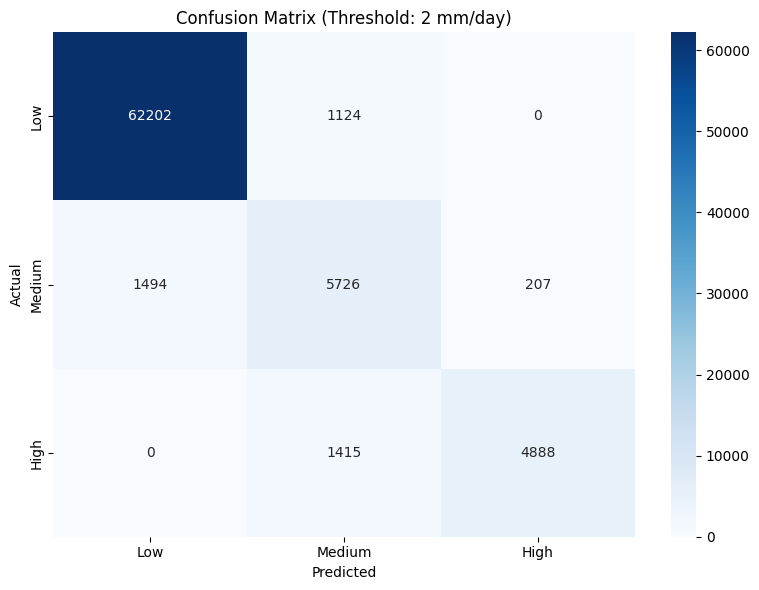

Model saved to models/water_requirement_model.h5
Model metadata saved to models/water_requirement_model.pkl
Training complete!


In [ ]:
print("Training model on synthetic data...")
history = irrigation_model.train_model(None)
print("Training complete!")

In [ ]:
print("Saving the model...")
irrigation_model.save_model()

Saving the model...
Model saved to models/water_requirement_model.h5
Model metadata saved to models/water_requirement_model.pkl


Evaluating model performance...
 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


===== Model Evaluation =====
RMSE: 0.4861 mm/day
MAE: 0.3541 mm/day
R² Score: 0.9250
Pearson's r: 0.9646

Classification Results (Threshold: 2 mm/day)
Weighted Avg Precision: 0.9478
Weighted Avg Recall: 0.9450
Weighted Avg F1-score: 0.9454

Confusion Matrix:
[[62202  1124     0]
 [ 1494  5726   207]
 [    0  1415  4888]]


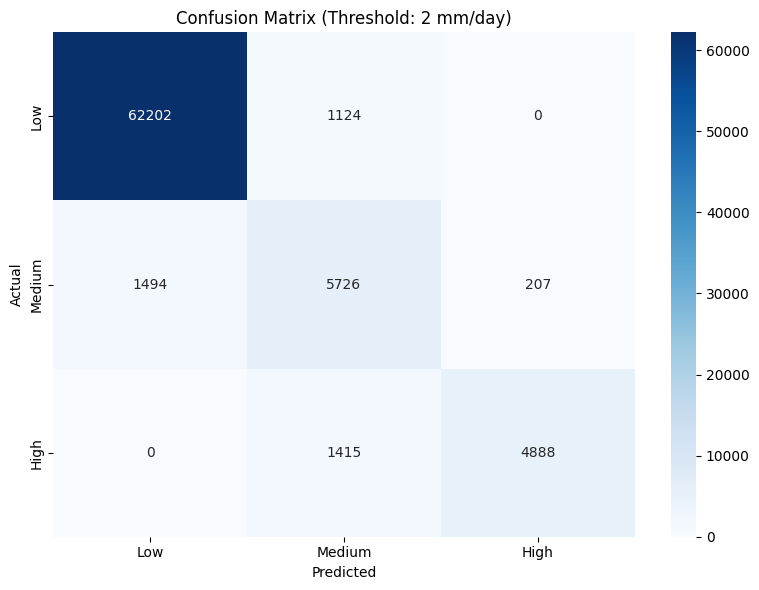

rmse: 0.4861
mae: 0.3541
r2: 0.9250
pearson_r: 0.9646


In [ ]:
print("Evaluating model performance...")
metrics = irrigation_model.evaluate_model()
for key, value in metrics.items():
    if isinstance(value, (float, int)):
        print(f"{key}: {value:.4f}")

In [ ]:
test_prediction = irrigation_model.predict_water_requirement(
    soil_moisture=50,
    temperature=25,
    precipitation=5,
    humidity=60,
    wind_speed=5
)
print("Prediction result:")
print(test_prediction)

Prediction result:
### Predicted Water Requirement

**Water Requirement:** 2.94 mm/day

**Based on:**
- Soil Moisture: 50.0%
- Temperature: 25.0°C
- Precipitation: 5.0 mm/day
- Humidity: 60.0%
- Wind Speed: 5.0 m/s

**Prediction Time:** Friday, April 18, 2025, 08:29 AM


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
print("Creating web interface...")
demo = irrigation_model.create_ui()
demo.launch(share=config['share'])

Creating web interface...
Using cache from '/content/.gradio/cached_examples/15' directory. If method or examples have changed since last caching, delete this folder to clear cache.

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://24775da74f93ea91c7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
